# **TASK: Classification using polynomial Support Vector Machines and parameters from Grid Search on preprocessed dataset with PAM50/LIMMA50 filters**

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/Drive')

Mounted at /content/Drive


In [2]:
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score, f1_score, matthews_corrcoef, classification_report, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from xlwt import Workbook
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import os


In [ ]:
import warnings
warnings.filterwarnings('ignore')
!pip freeze
! pip install scikit-learn==0.24.2 # Downgrading the scikit learn library to obtain same results of previous experiments and Convergence

In [7]:
# Current working directory and other paths -> change here
cwd = os.getcwd()
print(cwd)
!cd Drive/
path = cwd + "/Drive/My Drive/magistrale/BioinformaticsProject/data/" 
results_path = cwd + "/Drive/My Drive/magistrale/BioinformaticsProject/results/"

# Count per Million matrix
cpm_dataset = pd.read_csv(path+"CPM.csv",index_col=0) #read the main CPM dataset(67k × 719)
cpm_dataset = cpm_dataset.transpose() # (719 × 67k)
# Training and Testing datasets
training_ds =  pd.read_excel(path+"train.test.xlsx", sheet_name="train")
testing_ds = pd.read_excel(path+"train.test.xlsx", sheet_name="test")

# Feature space datesets
base_feature_space =path+"FEATURE_SPACES(RAW +CPM).xlsx"
# List of feature space name 
feature_space_files =["FEATURE_SPACE1(PAM)", "FEATURE_SPACE2","FEATURE_SPACE3(LIMMA)","FEATURE_SPACE4(LIMMA)", "FEATURE_SPACE7(pamsimilarity)","FEATURE_SPACE8(limmasimilarity)"]

/content


In [8]:
def extract_and_reduce_by_columns(path, sheet_name, columns_ds, name):
  '''
      Function to extract dataset given a path, an excel sheet
  '''
  full_df = pd.read_excel(path, sheet_name=sheet_name) # path of subdatset 

  full_list= full_df['isoform'].values.tolist()  #exatrct the list of isoforms names as list
  data = cpm_dataset[np.intersect1d(cpm_dataset.columns, full_list)]  # find the mutual isoform between main datset and subdatset 
  data.reset_index(inplace=True)
  data.rename(columns={ data.columns[0]: "sample_id" }, inplace = True)

  x = columns_ds['sample_id'].values.tolist()
  data1= data.loc[data['sample_id'].isin(x)]
  result = pd.merge(data1, columns_ds, on='sample_id')
  result.rename(columns={'sample_id.1':'subtype'}, inplace=True )
 
  # result.to_csv(name +".csv", index=False) # save as csv file 
  return result

In [9]:
#---- Training Data import:
train = extract_and_reduce_by_columns(base_feature_space, feature_space_files[4], training_ds, 'trainingset') 
X_train = train.drop(["sample_id","subtype"],  axis = 1)
samples_train = train.sample_id
Y_train=train.subtype
print("X_train size:", X_train.shape)

#---- Testing Data import:
test = extract_and_reduce_by_columns(base_feature_space, feature_space_files[4], testing_ds, 'testingset') 
X_test = test.drop(["sample_id","subtype"], axis = 1)
Y_test = test.subtype
print("X_test size:", X_test.shape)

X_train size: (550, 131)
X_test size: (137, 131)


In [10]:
# print(X_train)
# print("X_train contains the samples in the train dataset: ", X_train)
# print("Y_train contains the labels in the train dataset: ", Y_train)
print(train.describe())

       uc001cix.2  uc001ciy.2  uc001cmg.3   uc001ehz.2  uc001eib.2  \
count  550.000000  550.000000  550.000000   550.000000  550.000000   
mean    40.408772    4.283931   23.951193    87.395602    0.414667   
std     45.014878    4.635825   22.140506   259.518210    1.250225   
min      1.314143    0.000000    0.000000     0.000000    0.000000   
25%     12.623505    1.419944    9.018923    20.304825    0.071127   
50%     24.727756    2.877836   17.319513    41.153053    0.178128   
75%     49.138632    5.359911   33.132701    89.217146    0.446732   
max    386.657840   46.912066  150.100004  5622.010706   26.436802   

        uc001eic.2  uc001gcq.1  uc001gcr.1  uc001gxx.3  uc001hkm.2  ...  \
count   550.000000  550.000000  550.000000  550.000000  550.000000  ...   
mean      8.096468   11.154435    7.648704   25.412759  136.939897  ...   
std      49.087039   11.158464    8.608324   20.456094  110.622174  ...   
min       0.000000    0.000000    0.000000    1.479666    8.685904  .

In [11]:
def write_results(titles, results, name_of_file):
      '''
      Function to write results metrics and confing into a csv file 
      '''
      df = pd.DataFrame(results)
      df.to_csv(results_path+name_of_file + ".csv")

In [12]:
def plot_confusion_matrix(y_true, y_pred, le, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(le.transform(y_true), le.transform(y_pred))]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [13]:
# Configuration of parameters and names

#RESULTS_file_name
fs= "pam_similarity"
cv_results_file_name = "10-CV_results_Log_Reg"
test_results_file_name = "10-CV_TEST_Log_Reg"

#CV models attributes
#-10-folds:
column_titles_cv = ["metric", "degree",  "gamma", "C", "mean_CVtest_score", "std_CVtest_score",
                    "fold_0_test_score", "fold_1_test_score", "fold_2_test_score",
                    "fold_3_test_score", "fold_4_test_score", "fold_5_test_score",
                    "fold_6_test_score", "fold_7_test_score", "fold_8_test_score", "fold_9_test_score",
                    "mean_fit_time"]

column_titles_test = ["metric", "degree",  "gamma", "C", "10-f_CV", "TEST_Acc", "TEST_P", "TEST_R", "TEST_Ba"]

metrics = ["Balanced_accuracy","Accuracy"]
degree =[]
gamma=[]
C = []
cv_best = []
score_test_balanced_accuracy = []
score_test_accuracy = []
precision = []
recall = []

#'dual':[False]
#GridSearch attributes
# Set the parameters by cross-validation
#'l1_ratio':[0.5], 'solver': ['saga'], 'penalty':['elasticnet']

tuned_parameters = [{'kernel':['poly'], 'degree': [2], 'gamma': [10 ** i for i in range(-3,3)],
                     'max_iter':[1000], 'C': [10 ** i for i in range(-3,3)]}]
scores = ["balanced_accuracy","accuracy"]



# Tuning hyper-parameters for balanced_accuracy

Best parameters set found on development set:

{'C': 0.001, 'degree': 2, 'gamma': 100, 'kernel': 'poly', 'max_iter': 1000}

0.780 (+/-0.169) for {'C': 0.001, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly', 'max_iter': 1000}
0.783 (+/-0.137) for {'C': 0.001, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly', 'max_iter': 1000}
0.780 (+/-0.169) for {'C': 0.001, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly', 'max_iter': 1000}
0.780 (+/-0.164) for {'C': 0.001, 'degree': 2, 'gamma': 1, 'kernel': 'poly', 'max_iter': 1000}
0.782 (+/-0.134) for {'C': 0.001, 'degree': 2, 'gamma': 10, 'kernel': 'poly', 'max_iter': 1000}
0.784 (+/-0.134) for {'C': 0.001, 'degree': 2, 'gamma': 100, 'kernel': 'poly', 'max_iter': 1000}
0.780 (+/-0.169) for {'C': 0.01, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly', 'max_iter': 1000}
0.783 (+/-0.137) for {'C': 0.01, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly', 'max_iter': 1000}
0.780 (+/-0.169) for {'C': 0.01, 'degree': 2, 'g

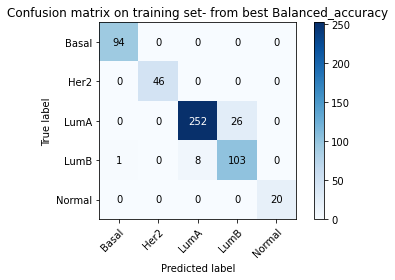

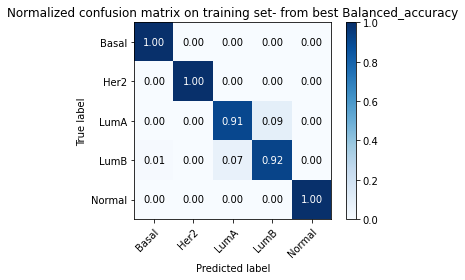

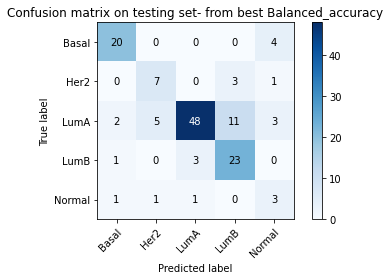

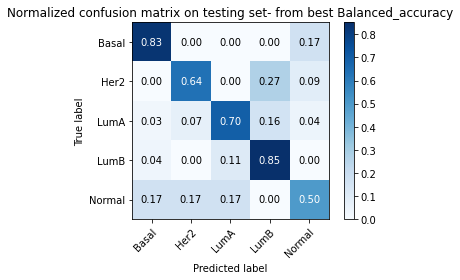

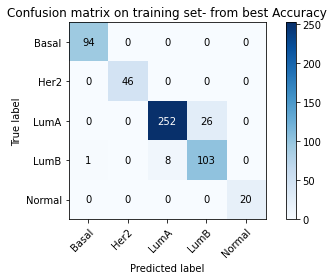

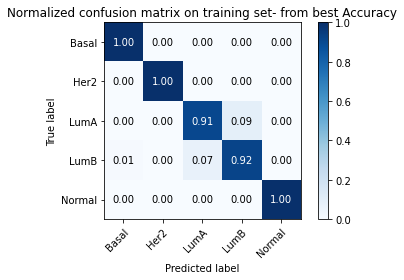

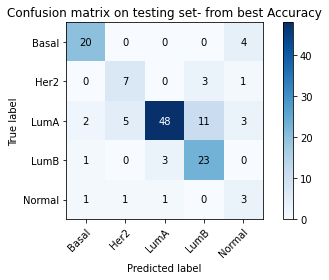

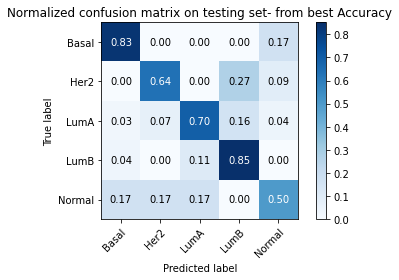

In [15]:
for index, score in enumerate(scores):
    # -------RESULTS in CROSS_VALIDATION-----------
    print("\n\n# Tuning hyper-parameters for %s" % score)
    print()

    #clf = GridSearchCV(LinearSVC(), tuned_parameters, scoring=score, cv=10)
    clf = GridSearchCV(svm.SVC(), tuned_parameters, scoring=score, cv=10)
    clf.fit(X_train, Y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)

    print()
    #appending CV_results
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    split_0_test_score = clf.cv_results_["split0_test_score"]
    split_1_test_score = clf.cv_results_["split1_test_score"]
    split_2_test_score = clf.cv_results_["split2_test_score"]
    split_3_test_score = clf.cv_results_["split3_test_score"]
    split_4_test_score = clf.cv_results_["split4_test_score"]
    split_5_test_score = clf.cv_results_["split5_test_score"]
    split_6_test_score = clf.cv_results_["split6_test_score"]
    split_7_test_score = clf.cv_results_["split7_test_score"]
    split_8_test_score = clf.cv_results_["split8_test_score"]
    split_9_test_score = clf.cv_results_["split9_test_score"]

    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    #saving CV_test_scores
    #10-folds
    cv_results = np.array([metrics[index],clf.cv_results_["param_degree"],clf.cv_results_["param_gamma"], clf.cv_results_["param_C"],
                        clf.cv_results_["mean_test_score"], clf.cv_results_["std_test_score"],
                           split_0_test_score, split_1_test_score, split_2_test_score, split_3_test_score, split_4_test_score,
                           split_5_test_score, split_6_test_score, split_7_test_score, split_8_test_score, split_9_test_score,
                           clf.cv_results_["mean_fit_time"] ])
    
    write_results(column_titles_cv, cv_results, cv_results_file_name + "-" + fs + "-" +metrics[index])
    print("printed")


     #--------TEST results-------
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = Y_test, clf.predict(X_test) # change here
    
    # bestCV_model results appending:
    degree.append(clf.best_params_["degree"])
    gamma.append(clf.best_params_["gamma"])
    C.append(clf.best_params_["C"])
    cv_best.append(clf.best_score_)

    score_test_balanced_accuracy.append(round(balanced_accuracy_score(y_true, y_pred), 3))
    score_test_accuracy.append(round(accuracy_score(y_true, y_pred), 3))
    precision.append(round(precision_score(y_true, y_pred, average="macro"), 3))
    recall.append(round(recall_score(y_true, y_pred, average="macro"), 3))

    ##CONFUSION_MATRIX
    np.set_printoptions(precision=2)
    class_names = np.array(["Basal", "Her2", "LumA", "LumB", "Normal"])

    le = LabelEncoder()
    le.fit(class_names)
    y_pred_train=clf.predict(X_train)

    # on train set
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(Y_train, y_pred_train, le, classes=class_names,
                          title='Confusion matrix on training set- from best ' + metrics[index])
    plt.savefig("/confusion_matrix_training-" + metrics[index] + ".png")
    # Plot normalized confusion matrix
    plot_confusion_matrix(Y_train, y_pred_train, le, classes=class_names, normalize=True,
                          title='Normalized confusion matrix on training set- from best ' + metrics[index])
    plt.savefig("/confusion_matrix_normalized_training-" + metrics[index] + ".png")
    
    #on test set
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(Y_test, y_pred, le, classes=class_names,
                          title='Confusion matrix on testing set- from best ' + metrics[index])
    plt.savefig("/confusion_matrix_testing-" + metrics[index] + ".png")
    # Plot normalized confusion matrix
    plot_confusion_matrix(Y_test, y_pred, le, classes=class_names, normalize=True,
                          title='Normalized confusion matrix on testing set- from best ' + metrics[index])
    plt.savefig("/confusion_matrix_normalized_testing-" + metrics[index] + ".png")

    #create a dataframe with training sample_id and y_pred_train and Y_train on columuns 
    #(columns names>> sample id, predicted subtype, original subtypes)and save it as a csv file with
    # title 'Predictions on training- from best' + metrics[index] +'.csv'
    pretraining = {'sample id' : train['sample_id'], 'predicted subtype' : y_pred_train, 'original subtypes' :Y_train} 
    pretraining_dataframe= pd.DataFrame(pretraining)
    pretrainingcsv = pretraining_dataframe.to_csv('Predictions on training- from best' + metrics[index]+ '.csv')


    #create a dataframe with testing sample_id y_pred and Y_test on columuns 
    #(columns names>> sample id, predicted subtype, original subtypes)and save it as a csv file with
    # title 'Predictions on testing- from best' + metrics[index] +'.csv'
    pretesting = {'sample id' : test['sample_id'], 'predicted subtype' : y_pred, 'original subtypes' :Y_test} 
    pretesting_dataframe= pd.DataFrame(pretesting)
    pretestingcsv = pretesting_dataframe.to_csv('Predictions on testing- from best' + metrics[index]+ '.csv')



In [16]:
test_results = np.array([metrics,degree, gamma, C, cv_best, score_test_accuracy,  precision, recall, score_test_balanced_accuracy])
write_results(column_titles_test, test_results, test_results_file_name)
print("saved")

saved


In [17]:
svmtrained = SVC(kernel="poly", max_iter= 1000, gamma = 100, degree =2, C = 0.001)
svmtrained.fit(X_train, Y_train) 

SVC(C=0.001, degree=2, gamma=100, kernel='poly', max_iter=1000)

In [18]:
y_pred=svmtrained.predict(X_test)
print(round(balanced_accuracy_score(Y_test, y_pred), 3))
print(round(accuracy_score(Y_test, y_pred), 3))
print(round(precision_score(Y_test, y_pred, average="macro"), 3))
print(round(recall_score(Y_test, y_pred, average="macro"), 3))

0.703
0.737
0.638
0.703


In [21]:
model_config_df = pd.DataFrame(svmtrained.support_vectors_, columns = X_train.columns)
model_coef =pd.DataFrame(svmtrained.dual_coef_)
model_config_df.to_csv(results_path +"vectors.poly.pam.csv")
model_coef.to_csv(results_path +"dual_coef.poly.pam.csv")

In [22]:
print(svmtrained.support_vectors_)

[[83.72 13.49 89.89 ...  5.05  0.72  2.37]
 [52.08  4.06 29.44 ...  1.51  1.57  5.48]
 [49.26  3.66 35.88 ...  0.    2.56  0.  ]
 ...
 [ 3.13  3.52  0.   ...  0.    0.45  0.  ]
 [10.97  3.33  8.48 ...  0.    0.    0.  ]
 [26.73  4.32 29.57 ...  0.    0.    0.  ]]
